# Lab Deep Learning/ Recurrent Neural Networks/ in keras

## Using Many-to-One for movie rating predicton

## Objective:
We will implement two different networks to perform automatic rating (0 or 1) of a movie given the text of its review.
We will use the ```imdb``` (internet movie database) dataset.

The reviews are already available in the form of indexes that point to a word dictionary: each word is already encoded as an index in the dictionary.

## Import packages

In [1]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector

## Parameters of the model

-  We only consider the ```top_words``` (first words in the word dictionary)
- We truncate/zero-pad each sequence a length ```max_review_length```

In [2]:
top_words = 5000
INDEX_FROM = 3
embedding_vector_length = 32

## Import IMDB data

In [3]:
# --- Import the IMDB data and only consider the ``top_words``` (most used words)
np.load.__defaults__=(None, True, True, 'ASCII')
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, index_from=INDEX_FROM)
np.load.__defaults__=(None, False, True, 'ASCII')

## Data content

- ```X_train``` and ```X_test``` are numpy arrays of lists.
  - each item in a list is the index in the word dictionary. So that a list is the sequence of index of words.

- ```y_train``` and ```y_test``` are a numpy arrays of the same dimension as ```X_train``` and ```X_test```
  - they contains the values 0 (bad movie) or 1 (good movie)

type(X_train): <class 'numpy.ndarray'>
number of training sequences: X_train.shape: (25000,)
type(X_train[0]): <class 'list'>
length of the first training sequence: len(X_train[0]): 218
length of the second training sequence: len(X_train[1]): 189
list of words index for the first training sequence: X_train[0]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 

Text(0.5, 1.0, 'Histogram of the lengths of reviews')

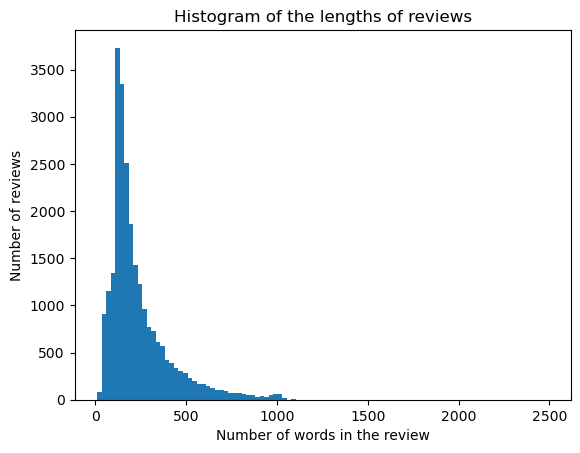

In [4]:
print("type(X_train):" , type(X_train))
print("number of training sequences: X_train.shape:", X_train.shape)
print("type(X_train[0]):",type(X_train[0]))
print("length of the first training sequence: len(X_train[0]):",len(X_train[0]))
print("length of the second training sequence: len(X_train[1]):",len(X_train[1]))
print("list of words index for the first training sequence: X_train[0]:", X_train[0] )
len_list = [len(train) for train in X_train]
print("maximum length of a training sequence:", max(len_list))

import matplotlib.pyplot as plt
plt.hist(len_list, 100)
plt.xlabel('Number of words in the review')
plt.ylabel('Number of reviews')
plt.title("Histogram of the lengths of reviews")

## Details of how the reviews are encoded

In [5]:
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X_train[1000] ))

<START> although i had seen <UNK> in a theater way back in <UNK> i couldn't remember anything of the plot except for vague images of kurt thomas running and fighting against a backdrop of stone walls and disappointment regarding the ending br br after reading some of the other reviews i picked up a copy of the newly released dvd to once again enter the world of <UNK> br br it turns out this is one of those films produced during the <UNK> that would go directly to video today the film stars <UNK> <UNK> kurt thomas as jonathan <UNK> <UNK> out of the blue to <UNK> the nation of <UNK> to enter and hopefully win the game a <UNK> <UNK> <UNK> by the khan who <UNK> his people by yelling what sounds like <UNK> power the goal of the mission involves the star wars defense system jonathan is trained in the martial arts by princess <UNK> who never speaks or leaves the house once trained tries to blend in with the <UNK> by wearing a bright red <UNK> with <UNK> of blue and white needless to say <UNK>

In [6]:
print("type(y_train):", type(y_train))
print("y_train.shape:", y_train.shape)

type(y_train): <class 'numpy.ndarray'>
y_train.shape: (25000,)


In [7]:
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_test.shape: (25000,)
y_test.shape: (25000,)


## Data processing

Sequences (represented as a list of values) in ```X_train``` represent the reviews.
They can have different length.
To train the network we should modify them so that they all have the same length.
We do this by:
- truncating the ones that are too long
- padding-with-zero them the ones that are too short.

This is obtained using ```sequence.pad_sequences``` of keras.

len(X_train[0]): 100
len(X_train[1]): 100
X_train[0]: [   2    5 1960  279   13   92  124  803   52   21  279   14    9   43
    6  762    7  595   15   16    2   23    4 1071  467    4  403    7
  628 2219    8   97    6  171 3596   99  387   72   97   12  788   15
   13  161  459   44    4 3939 1101  173   21   69    8  401    2    4
  481   88   61 4731  238   28   32   11   32   14    9    6  545 1332
  766    5  203   73   28   43   77  317   11    4    2  953  270   17
    6 3616   13  545  386   25   92 1142  129  278   23   14  241   46
    7  158]
maximum length of a training sequence: 100


Text(0.5, 1.0, 'Histogram of the lengths of reviews')

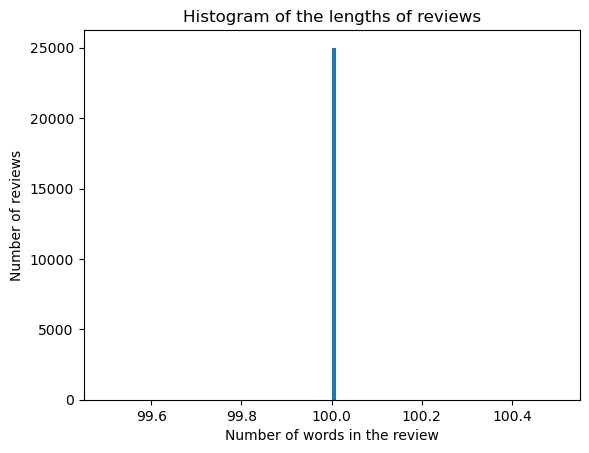

In [8]:
# --- truncate and pad input sequences
max_review_length = 100

X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)


print("len(X_train[0]):", len(X_train[0]))
print("len(X_train[1]):", len(X_train[1]))
print("X_train[0]:", X_train[100])

len_list = [len(train) for train in X_train]
print("maximum length of a training sequence:", max(len_list))

plt.hist(len_list, 100)
plt.xlabel('Number of words in the review')
plt.ylabel('Number of reviews')
plt.title("Histogram of the lengths of reviews")

# First model

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_RNN_01.png">

In the first model, we will simply
- learn a word embedding  (```Embedding``` layer in keras) and apply it to each item of the sequence,
  -  in keras, embedding is not a matrix going from one-hot-encoding to embedding, but is a layer that goes from index-in-word-dictionary to embedding
  - the embedding goes from ```top_words``` dimensions to  ```embedding_vector_length``` dimensions
- average the embedding obtained for each word of a sequence over all words of the sequence (using ```K.mean``` and ```Lambda``` from the keras backend)
- apply a fully connected (```Dense``` layer in keras) which output activation is a sigmoid (predicting the 0 or 1 rating)

We will code this model
- First, using the Sequential API of keras (https://keras.io/models/sequential/)
- Secondly, using the Functional API of keras (https://keras.io/getting-started/functional-api-guide/)


In [9]:
K.clear_session()

In [10]:
# --- create the model
type = 'functional'  # 'sequential' or 'functional'


# --- Using the Sequential API
if type == 'sequential':
    model = Sequential()
    model.add(
            Embedding(
                input_dim = top_words,
                output_dim = embedding_vector_length,
                input_length=max_review_length
                )
            )
    model.add(Lambda(lambda x: K.mean(x, axis=1)))
    model.add(Dense(1, activation='sigmoid'))


   
# --- Using the Functional API
else :
    inputs = Input(shape=(max_review_length,))
    embeddings = Embedding( input_dim = top_words,
                            output_dim = embedding_vector_length,
                            input_length = max_review_length)(inputs)
    mean_emb = Lambda(lambda x: K.mean(x, axis=1))(embeddings)
    outputs = Dense(1, activation='sigmoid')(mean_emb)
    model = Model(inputs=inputs, outputs=outputs)


print(model.summary())

d:\Applications\miniconda\envs\test\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,033 (625.13 KB)

 Trainable params: 160,033 (625.13 KB)

 Non-trainable params: 0 (0.00 B)

None


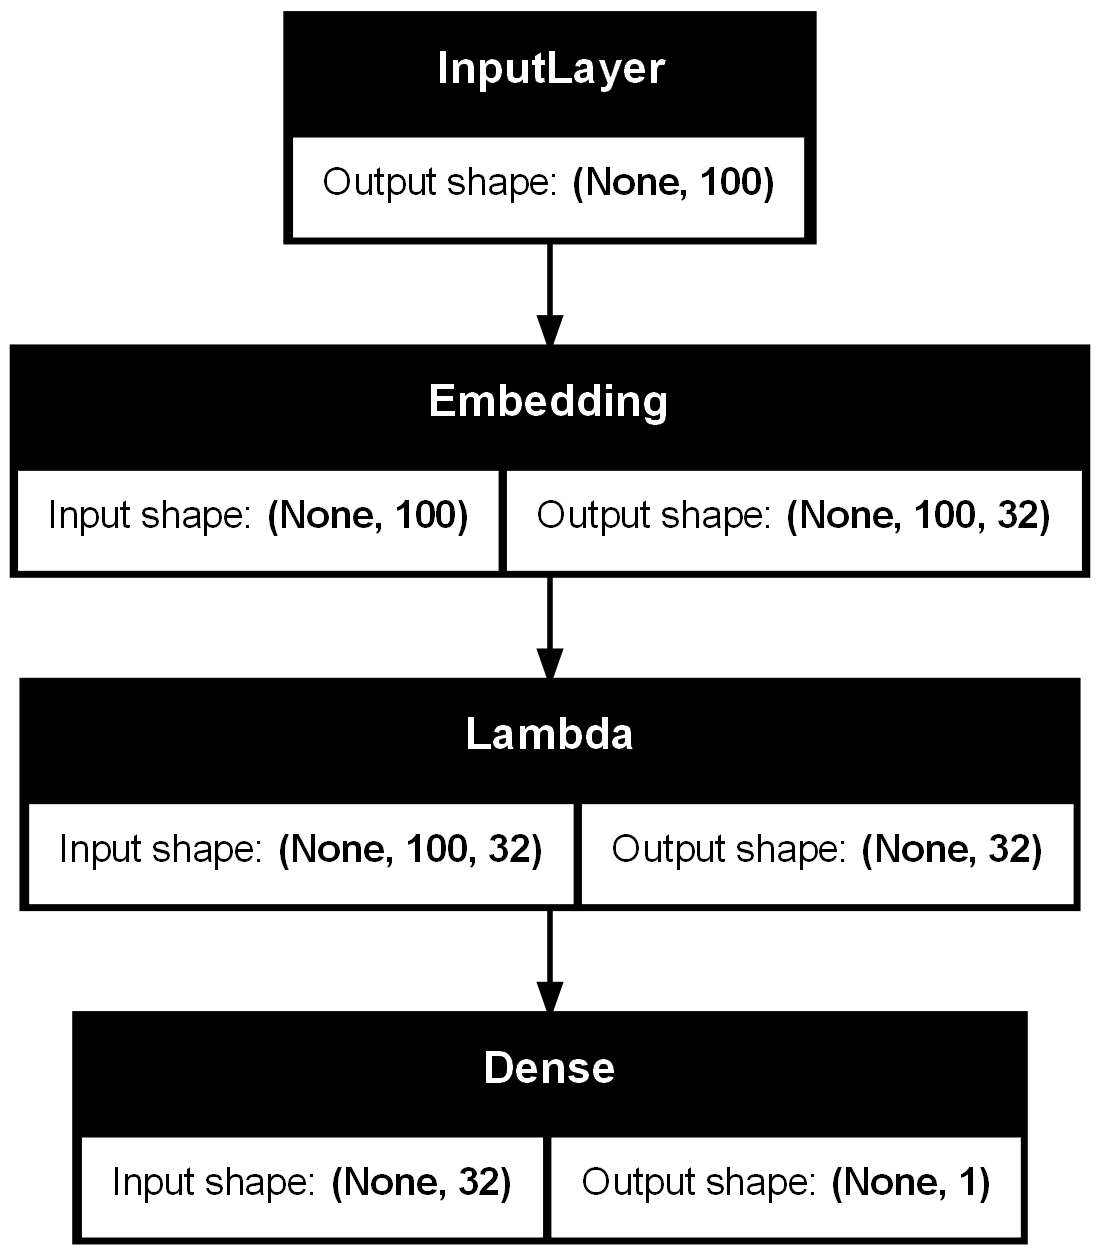

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model=model, show_shapes=True, to_file='D:/Desktop/Coding-Projects/DeepLearning_course/model-mean.png')

In [12]:
# --- compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6414 - loss: 0.6649 - val_accuracy: 0.7781 - val_loss: 0.5412
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8034 - loss: 0.4989 - val_accuracy: 0.8232 - val_loss: 0.4261
Epoch 3/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8434 - loss: 0.3961 - val_accuracy: 0.8331 - val_loss: 0.3807


## Results

After only 3 epochs, we obtain an accuracy around 83-84% for the test data.

In [13]:
# --- Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 83.31%


## Using the trained embedding to find equivalence between words

Since the embedding is part of the models, we can look at the trained embedding matrix $E$ and use it to get the most similar words (according to the trained matrix $E$) in the dictionary.
Use the weights of the ```Embedding``` layer to find the most similar words to ```great```. We will use an Euclidean distance for that.
- Retrieve the weights of the ```Embedding layer```
- Get the position of ```great``` in the dictionary
- Get the word-embedding of ```great```
- Find (using Euclidean distance), the closest embedded-words to ```great```

In [14]:

model.layers[1].get_weights()[0].shape 
# model.layers[1] if using the functional API and model.layers[0] if using the sequential API

(5000, 32)

In [15]:
# Lets try to find similar words to "great"
word = 'great'
n_closest = 10
if type == 'functional':
    weights = model.layers[1].get_weights()[0]
elif type == 'sequential':
    weights = model.layers[0].get_weights()[0]

word_id = word_to_id[word]
word_v = weights[word_id]
dist_v = np.linalg.norm(weights - word_v, axis=1)
closest_ids = np.argsort(dist_v)[1:n_closest+1]


for i in np.argsort(dist_v)[0:20]: print(id_to_word[i])

great
excellent
perfect
7
wonderful
highly
8
amazing
best
love
favorite
9
superb
today
brilliant
fantastic
well
loved
recommended
definitely


# Second model

In the second model, we will replace
- the average over the sequence of the obtained embedding
- by a RNN layer (more precisely an ```LSTM```) in a Many-To-One configuration with $n_a=128$

We will code this model
- First, using the Sequential API of keras (https://keras.io/models/sequential/)
- Secondly, using the Functional API of keras (https://keras.io/getting-started/functional-api-guide/)



In [16]:
K.clear_session()

In [17]:
# --- create the model

# --- Using the Sequential API
if type == 'sequential':
    model = Sequential()
    model.add(Embedding(
        input_dim=top_words,
        output_dim=embedding_vector_length,
        input_length=max_review_length))
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))


# --- Using the Functional API
else:
    inputs = Input(shape=(max_review_length,))
    embeddings = Embedding(input_dim=top_words,
                           output_dim=embedding_vector_length,
                           input_length=max_review_length)(inputs)
    lstm_layer = LSTM(128)(embeddings)
    outputs = Dense(1, activation='sigmoid')(lstm_layer)
    model = Model(inputs=inputs, outputs=outputs)

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,561 (947.50 KB)

 Trainable params: 242,561 (947.50 KB)

 Non-trainable params: 0 (0.00 B)

None


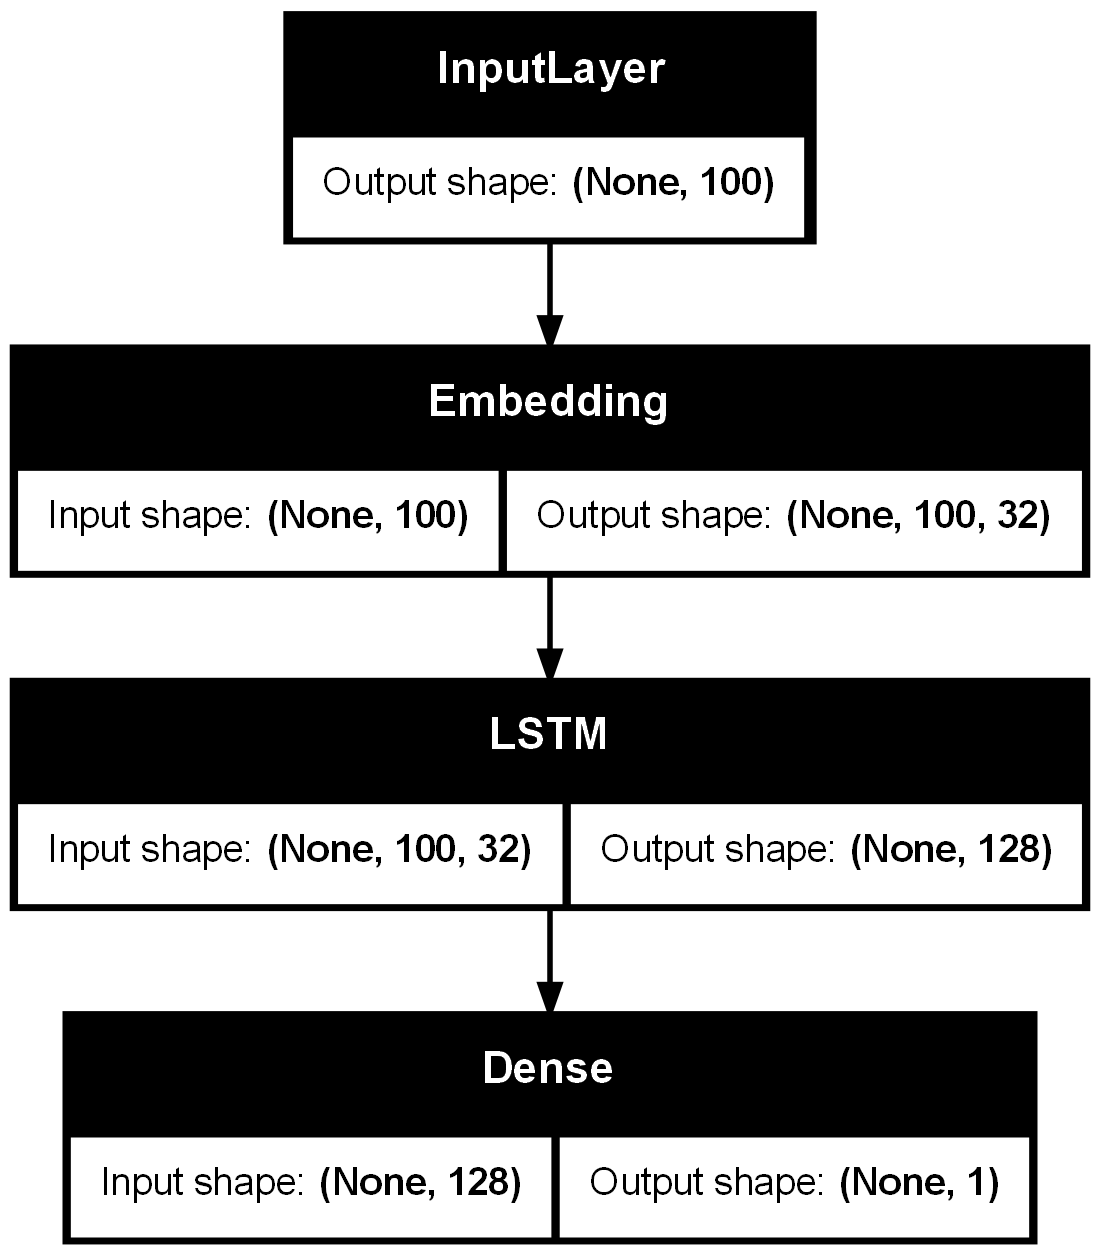

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model=model, show_shapes=True, to_file='D:/Desktop/Coding-Projects/DeepLearning_course/model-LSTM.png')

In [19]:
# --- compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 58s 140ms/step - accuracy: 0.6641 - loss: 0.5774 - val_accuracy: 0.8436 - val_loss: 0.3600
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 53s 136ms/step - accuracy: 0.8690 - loss: 0.3104 - val_accuracy: 0.8412 - val_loss: 0.3634
Epoch 3/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 57s 145ms/step - accuracy: 0.8972 - loss: 0.2624 - val_accuracy: 0.8491 - val_loss: 0.3593


## Results

After only 3 epochs, we obtain an accuracy around 84-85% for the test data.

In [20]:
# --- Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 84.91%
